In [1]:
import os
import warnings

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("‚úì TOKENIZERS_PARALLELISM configurado a 'false' para evitar warnings")

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

print("‚úì Configuraci√≥n de warnings completada")

‚úì TOKENIZERS_PARALLELISM configurado a 'false' para evitar warnings
‚úì Configuraci√≥n de warnings completada


# Modelado de T√≥picos con FASTopic

Este notebook implementa un an√°lisis de t√≥picos usando FASTopic sobre las opiniones tur√≠sticas clasificadas. Utiliza LangChain con GPT-4o-mini para asignar nombres sem√°nticamente coherentes a los t√≥picos identificados y compara resultados con BERTopic.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import sys
from dotenv import load_dotenv

sys.path.append('../scripts')

from topicos import (
    configurar_clasificador_topicos, 
    configurar_fastopic_inteligente,
    LimpiadorTextoMejorado, 
    mostrar_ejemplos_limpieza,
    evaluar_modelo_topicos,
    extraer_palabras_fastopic,
    mostrar_metricas
)

from topicos.utils_topicos import (
    procesar_topicos_fastopic,
    obtener_asignaciones_topicos_fastopic,
    visualizar_distribucion_topicos_fastopic,
    mostrar_ejemplos_por_topico_fastopic,
    generar_reporte_fastopic
)

load_dotenv()

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

‚úì Modelo spaCy espa√±ol cargado
‚úì Modelo spaCy ingl√©s cargado
‚úì Modelo spaCy ingl√©s cargado
‚úì Modelo spaCy portugu√©s cargado
‚úì Modelo spaCy portugu√©s cargado
‚úì Modelo spaCy franc√©s cargado
‚úì Modelo spaCy franc√©s cargado
‚úì Modelo spaCy italiano cargado
Descargando wordnet...
‚úì Modelo spaCy italiano cargado
Descargando wordnet...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/victorwkey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
clasificador_topicos = configurar_clasificador_topicos()

In [4]:
CIUDAD_ANALIZAR = "Cdmx"
df = pd.read_csv('../data/processed/dataset_opiniones_analisis.csv')

if 'TopicoConFASTopic' not in df.columns:
    df['TopicoConFASTopic'] = np.nan

print(f"Dataset cargado: {df.shape[0]} opiniones")
print(f"Distribuci√≥n total por ciudad:")
print(df['Ciudad'].value_counts())

df_ciudad = df[df['Ciudad'] == CIUDAD_ANALIZAR].copy()

columna_texto = 'TituloReviewLimpio'

texts = df_ciudad[columna_texto].dropna().tolist()

Dataset cargado: 2459 opiniones
Distribuci√≥n total por ciudad:
Ciudad
Mazatlan           499
Puebla             499
Puerto_vallarta    489
Cdmx               489
Cancun             483
Name: count, dtype: int64


In [ ]:
columna_limpia = "TituloReviewLimpio"

limpiar_de_nuevo = False

if columna_limpia not in df.columns or limpiar_de_nuevo:
    limpiador = LimpiadorTextoMejorado(idiomas=['spanish', 'english'])
    
    df = limpiador.limpiar_dataframe(
        df,
        columna_texto='TituloReview',
        nombre_columna_limpia=columna_limpia,
        aplicar_traduccion=True,
        filtrar_adjetivos=True,  # Nueva opci√≥n para filtrar adjetivos
        filtrar_solo_espanol=True,  # Nueva opci√≥n para filtrar solo textos en espa√±ol
        aplicar_lematizacion=True,
        min_longitud_palabra=2,
        max_palabras=None
    )
    
    df.to_csv('../data/processed/dataset_opiniones_analisis.csv', index=False)

df_ciudad = df[df['Ciudad'] == CIUDAD_ANALIZAR].copy()
texts = df_ciudad[columna_texto].dropna().tolist()

üåê Aplicando traducci√≥n EN‚ÜíES...
   Textos en ingl√©s detectados: 297
   Total textos: 2459
   Textos en ingl√©s detectados: 297
   Total textos: 2459
   üìä Textos detectados en ingl√©s: 297 de 2459 total
   üìä Textos detectados en ingl√©s: 297 de 2459 total


üåê Procesando traducciones:  26%|‚ñà‚ñà‚ñå       | 643/2459 [01:40<04:42,  6.43texto/s] 



KeyboardInterrupt: 

In [ ]:
topic_model, reporte_optimizacion = configurar_fastopic_inteligente(texts)
    
print("ü§ñ Configuraci√≥n autom√°tica de FASTopic completada")
print(reporte_optimizacion)

2025-09-22 22:16:53,235 - FASTopic - use device: cuda


ü§ñ Configuraci√≥n autom√°tica de FASTopic completada

üìä CONFIGURACI√ìN AUTOM√ÅTICA DE FASTOPIC

üìà An√°lisis del Corpus:
  üìÑ Documentos: 489
  üìù Palabras promedio por doc: 53.2
  üî§ Vocabulario √∫nico: 2,413

üéØ Configuraci√≥n:
  üè∑Ô∏è N√∫mero de t√≥picos: 7
  üìö Tama√±o vocabulario: 2,413
  üåç Modelo embeddings: paraphrase-multilingual-MiniLM-L12-v2
  üîß Tokenizer: Multiidioma (ES, EN, PT, FR, IT)



In [ ]:
print("\nüöÄ Entrenando modelo FASTopic...")
inicio_entrenamiento = time.time()

top_words, doc_topic_dist = topic_model.fit_transform(texts, epochs=200)

tiempo_entrenamiento = time.time() - inicio_entrenamiento
print(f"‚úÖ Entrenamiento completado en {tiempo_entrenamiento:.2f} segundos")

2025-09-22 22:16:53,258 - FASTopic - First fit the model.



üöÄ Entrenando modelo FASTopic...


parsing texts: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 489/489 [00:06<00:00, 72.60it/s] 
2025-09-22 22:17:11,125 - TopMost - Real vocab size: 477
2025-09-22 22:17:11,126 - TopMost - Real training size: 489 	 avg length: 14.969
parsing texts: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 489/489 [00:06<00:00, 72.60it/s]
2025-09-22 22:17:11,125 - TopMost - Real vocab size: 477
2025-09-22 22:17:11,126 - TopMost - Real training size: 489 	 avg length: 14.969


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Training FASTopic:  30%|‚ñà‚ñà‚ñâ       | 59/200 [00:06<00:15,  9.16it/s]2025-09-22 22:17:19,632 - FASTopic - Epoch: 060 loss: 93.029
2025-09-22 22:17:19,632 - FASTopic - Epoch: 060 loss: 93.029
Training FASTopic:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 109/200 [00:13<00:10,  8.97it/s]2025-09-22 22:17:25,898 - FASTopic - Epoch: 110 loss: 90.100
2025-09-22 22:17:25,898 - FASTopic - Epoch: 110 loss: 90.100
Training FASTopic: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 200/200 [00:25<00:00,  7.75it/s]

Topic 0: misa tour duda pareja fe bas milagro recomeir volverio importancia helado guadalupe sentir civilizacion recomendado
Topic 1: mural castillo palacio chap rivera interior artes parque espectaculo ballet ocasion dec estilo pesos mueble
Topic 2: iglesia mercado barrio virgen capilla aloj escalera bas top mujer oficina hogar jardin vendedor cola
Topic 3: casa fri tiempo valer pena hora llegar visitar caminar 5 tomar sitio visita pasar antelacion
Topic 4: museo coleccion piso arte pieza obra planta rod antrop re deber historia artefacto guia extremadamente
Topic 5: animal acu grupo cuidado servicio nino actividad personal horario faltar chico promo exper fila edad
Topic 6: ciudad plaza mexico templo centro catedral restaurante calle vida mexic constitucion mexicano az vis pueblo
‚úÖ Entrenamiento completado en 45.17 segundos


In [ ]:
import numpy as np

def select_topics_stat(doc_vec, threshold, max_topics=3):
    """
    Selecciona t√≥picos estad√≠sticamente mejores que azar (95% confianza).
    - Usa un threshold ya calculado.
    - M√°ximo max_topics t√≥picos seleccionados.
    """
    doc_vec = np.array(doc_vec)
    order = np.argsort(doc_vec)[::-1]

    selected = []
    for i in order:
        if doc_vec[i] > threshold:
            selected.append(i)
        if len(selected) >= max_topics:
            break

    return selected

# Calcular solo una vez
N = len(doc_topic_dist)
C = doc_topic_dist.shape[1]
p = 1 / C
sigma = np.sqrt(p * (1 - p) / N)
threshold = p + 1.96 * sigma

# Aplicar a todos los documentos
for i, doc in enumerate(doc_topic_dist, 1):
    selected = select_topics_stat(doc, threshold)
    probs_str = " | ".join(f"{p:.2f}" for p in doc)
    print(f"Documento {i}: [{probs_str}] -> T√≥picos seleccionados: {selected}, Umbral: {threshold:.3f}")


Documento 1: [0.10 | 0.15 | 0.06 | 0.05 | 0.03 | 0.47 | 0.15] -> T√≥picos seleccionados: [5], Umbral: 0.174
Documento 2: [0.05 | 0.57 | 0.09 | 0.05 | 0.07 | 0.09 | 0.08] -> T√≥picos seleccionados: [1], Umbral: 0.174
Documento 3: [0.13 | 0.18 | 0.13 | 0.09 | 0.02 | 0.35 | 0.09] -> T√≥picos seleccionados: [5, 1], Umbral: 0.174
Documento 4: [0.04 | 0.52 | 0.05 | 0.05 | 0.17 | 0.01 | 0.17] -> T√≥picos seleccionados: [1], Umbral: 0.174
Documento 5: [0.06 | 0.13 | 0.11 | 0.11 | 0.10 | 0.01 | 0.48] -> T√≥picos seleccionados: [6], Umbral: 0.174
Documento 6: [0.33 | 0.04 | 0.21 | 0.05 | 0.01 | 0.33 | 0.02] -> T√≥picos seleccionados: [5, 0, 2], Umbral: 0.174
Documento 7: [0.04 | 0.50 | 0.19 | 0.07 | 0.07 | 0.03 | 0.11] -> T√≥picos seleccionados: [1, 2], Umbral: 0.174
Documento 8: [0.12 | 0.49 | 0.12 | 0.04 | 0.14 | 0.03 | 0.05] -> T√≥picos seleccionados: [1], Umbral: 0.174
Documento 9: [0.24 | 0.39 | 0.04 | 0.03 | 0.03 | 0.05 | 0.24] -> T√≥picos seleccionados: [1, 0, 6], Umbral: 0.174
Documento 

In [ ]:
topic_info = procesar_topicos_fastopic(topic_model, doc_topic_dist, top_words)

# Preparar informaci√≥n de todos los t√≥picos para procesamiento en lote
topics_info_text = ""
for _, row in topic_info.iterrows():
    topic_id = row['Topic']
    keywords = row['Keywords']
    if keywords and keywords not in ["Sin palabras", "Error en procesamiento"]:
        topics_info_text += f"T√≥pico {topic_id}: {keywords}\n"

resultado = clasificador_topicos.invoke({"topics_info": topics_info_text})

topic_names = {}
for topic_label in resultado.topics:
    topic_names[topic_label.topic_id] = topic_label.label

topic_info['Name'] = topic_info['Topic'].map(topic_names)

In [ ]:
print(topics_info_text)

T√≥pico 0: misa, tour, duda, pareja, fe, bas, milagro, recomeir, volverio, importancia
T√≥pico 1: mural, castillo, palacio, chap, rivera, interior, artes, parque, espectaculo, ballet
T√≥pico 2: iglesia, mercado, barrio, virgen, capilla, aloj, escalera, bas, top, mujer
T√≥pico 3: casa, fri, tiempo, valer, pena, hora, llegar, visitar, caminar, 5
T√≥pico 4: museo, coleccion, piso, arte, pieza, obra, planta, rod, antrop, re
T√≥pico 5: animal, acu, grupo, cuidado, servicio, nino, actividad, personal, horario, faltar
T√≥pico 6: ciudad, plaza, mexico, templo, centro, catedral, restaurante, calle, vida, mexic



In [ ]:
print(resultado)

topics=[TopicLabel(topic_id=0, label='Religioso'), TopicLabel(topic_id=1, label='Arte y Cultura'), TopicLabel(topic_id=2, label='Patrimonio Religioso'), TopicLabel(topic_id=3, label='Visitas Guiadas'), TopicLabel(topic_id=4, label='Museos'), TopicLabel(topic_id=5, label='Vida Marina'), TopicLabel(topic_id=6, label='Sitios Hist√≥ricos')]


In [ ]:
# Obtener asignaciones de t√≥picos para documentos
topic_assignments, topic_names_assigned, topic_probabilities = obtener_asignaciones_topicos_fastopic(
    doc_topic_dist, 
    topic_names, 
    threshold=0.1
)

# Procesar solo datos de la ciudad seleccionada
df_con_topicos = df_ciudad.dropna(subset=[columna_texto]).copy()
df_con_topicos['Topico'] = topic_assignments
df_con_topicos['Topico_Nombre'] = topic_names_assigned
df_con_topicos['Probabilidad_Topico'] = topic_probabilities

# Verificar si la ciudad ya ten√≠a resultados previos
indices_ciudad = df_con_topicos.index
opiniones_previas = df.loc[indices_ciudad, 'TopicoConFASTopic'].notna().sum()

if opiniones_previas > 0:
    print(f"üîÑ SOBRESCRIBIENDO resultados previos para {CIUDAD_ANALIZAR}:")
    print(f"   üìù Opiniones con t√≥picos previos: {opiniones_previas}")
    print(f"   üÜï Nuevas asignaciones de t√≥picos: {len(df_con_topicos)}")
else:
    print(f"üÜï PRIMERA VEZ procesando {CIUDAD_ANALIZAR}:")
    print(f"   üìù Nuevas asignaciones de t√≥picos: {len(df_con_topicos)}")

# Actualizar el dataset original con los t√≥picos de la ciudad analizada
df.loc[indices_ciudad, 'TopicoConFASTopic'] = df_con_topicos['Topico_Nombre']

print(f"\n‚úÖ Actualizaci√≥n completada para {CIUDAD_ANALIZAR}")
print(f"Distribuci√≥n de t√≥picos en {CIUDAD_ANALIZAR}:")
topico_counts = df_con_topicos['Topico_Nombre'].value_counts()
print(topico_counts)

print(f"\nPorcentaje de opiniones por t√≥pico en {CIUDAD_ANALIZAR}:")
topico_pct = (topico_counts / len(df_con_topicos) * 100).round(2)
for topico, pct in topico_pct.items():
    print(f"{topico}: {pct}%")

print(f"\nEstado actualizaci√≥n dataset completo:")
print(f"Total opiniones: {len(df)}")
print(f"Opiniones con t√≥pico FASTopic asignado: {df['TopicoConFASTopic'].notna().sum()}")
print(f"Opiniones pendientes: {df['TopicoConFASTopic'].isna().sum()}")

üîÑ SOBRESCRIBIENDO resultados previos para Cdmx:
   üìù Opiniones con t√≥picos previos: 489
   üÜï Nuevas asignaciones de t√≥picos: 489

‚úÖ Actualizaci√≥n completada para Cdmx
Distribuci√≥n de t√≥picos en Cdmx:
Topico_Nombre
Museos                  96
Vida Marina             93
Sitios Hist√≥ricos       75
Religioso               71
Arte y Cultura          68
Patrimonio Religioso    55
Visitas Guiadas         31
Name: count, dtype: int64

Porcentaje de opiniones por t√≥pico en Cdmx:
Museos: 19.63%
Vida Marina: 19.02%
Sitios Hist√≥ricos: 15.34%
Religioso: 14.52%
Arte y Cultura: 13.91%
Patrimonio Religioso: 11.25%
Visitas Guiadas: 6.34%

Estado actualizaci√≥n dataset completo:
Total opiniones: 2459
Opiniones con t√≥pico FASTopic asignado: 489
Opiniones pendientes: 1970


In [ ]:
# Obtener asignaciones de t√≥picos para documentos
topic_assignments, topic_names_assigned, topic_probabilities = obtener_asignaciones_topicos_fastopic(
    doc_topic_dist, 
    topic_names, 
    threshold=0.1
)

# Procesar solo datos de la ciudad seleccionada
df_con_topicos = df_ciudad.dropna(subset=[columna_texto]).copy()
df_con_topicos['Topico'] = topic_assignments
df_con_topicos['Topico_Nombre'] = topic_names_assigned
df_con_topicos['Probabilidad_Topico'] = topic_probabilities

# Actualizar el dataset original con los t√≥picos de la ciudad analizada
indices_ciudad = df_con_topicos.index
df.loc[indices_ciudad, 'TopicoConFASTopic'] = df_con_topicos['Topico_Nombre']

In [ ]:
# Mostrar ejemplos de opiniones por t√≥pico
mostrar_ejemplos_por_topico_fastopic(
    df_con_topicos, 
    topico_col='Topico_Nombre',
    texto_col='TituloReview',
    n_ejemplos=3,
    top_n_topicos=5
)

üìö EJEMPLOS DE OPINIONES POR T√ìPICO

üè∑Ô∏è 1. Museos
üìä Total de opiniones: 96
üìù Ejemplos:
   1. A waste of my time!. I'm glad ( as a senior citizen.) l didn't have to pay to get into this absolute...
   2. un museo escondido. un gran museo dentro existe un gran museo que pocos conocen un rinc√≥n con maravi...
   3. Best museum in CMDX!. Incredible museum and such a great way to spend a few hours in beautiful CMDX!...
----------------------------------------------------------------------

üè∑Ô∏è 2. Vida Marina
üìä Total de opiniones: 93
üìù Ejemplos:
   1. 10 de 10. Simplemente espectacular! No se lo pierdan el ballet folkl√≥rico. Tienen mucho talento esos...
   2. Ballet Folkl√≥rico de M√©xico de Amalia Hern√°ndez. excelente producci√≥n, que te llena los sentidos y t...
   3. Unique Place, Exceeded My Expectations. This place truly exceeded my expectations. It's unique, thou...
----------------------------------------------------------------------

üè∑Ô∏è 3. Sitios Hist√

In [ ]:
# ===== COMPARACI√ìN TEXTO ORIGINAL VS TEXTO LIMPIO =====
if 'TituloReviewLimpio' in df_con_topicos.columns:
    print(f"üîç Comparaci√≥n de ejemplos - Original vs Limpio ({CIUDAD_ANALIZAR}):")
    print("=" * 80)
    
    # Seleccionar algunos ejemplos para mostrar la diferencia
    ejemplos_muestra = df_con_topicos.sample(n=min(10, len(df_con_topicos)))
    
    for i, (_, row) in enumerate(ejemplos_muestra.iterrows(), 1):
        print(f"\nüìÑ EJEMPLO {i} - T√≥pico: {row['Topico_Nombre']}")
        print(f"üî∏ Original: {row['TituloReview']}")
        print(f"üîπ Limpio:   {row['TituloReviewLimpio']}")
        print(f"üìä Probabilidad: {row['Probabilidad_Topico']:.3f}")
        
        # Calcular estad√≠sticas del ejemplo
        len_orig = len(str(row['TituloReview']))
        len_limpio = len(str(row['TituloReviewLimpio']))
        reduccion = ((len_orig-len_limpio)/len_orig*100) if len_orig > 0 else 0
        print(f"üìâ Reducci√≥n: {len_orig} ‚Üí {len_limpio} caracteres ({reduccion:.1f}%)")
        print("-" * 80)

üîç Comparaci√≥n de ejemplos - Original vs Limpio (Cdmx):

üìÑ EJEMPLO 1 - T√≥pico: Vida Marina
üî∏ Original: Fue divertida, entretenida y adecuada a varias edades. Buena, personal amable y atracciones did√°cticas, es muy amplio y con muchas actividades a realizar, accesos y promociones adecuadas a las necesidades.
üîπ Limpio:   ser y a varios edad personal y atracci√≥n ser mucho y con mucho actividad a realizar acceso y promo a el necesidad
üìä Probabilidad: 0.844
üìâ Reducci√≥n: 205 ‚Üí 113 caracteres (44.9%)
--------------------------------------------------------------------------------

üìÑ EJEMPLO 2 - T√≥pico: Religioso
üî∏ Original: Comodidad. El mejor lugar sin duda. Es bueno saber que hay castillos de verdad en nuestro continente. El √∫nico pero fue que era muy alto. As√≠ que vayan muy c√≥modos por favor.
üîπ Limpio:   como el lugar sin duda ser bueno saber que haber castillo de verdad en nuestro continente el pero ser que ser mucho asi que ir mucho por favor
üìä Pro

In [ ]:
# ===== VISUALIZACIONES ESPEC√çFICAS DE FASTOPIC =====

# Generar visualizaci√≥n de t√≥picos
fig_topics = topic_model.visualize_topic(top_n=min(8, len(topic_info)))
fig_topics.update_layout(title=f"Palabras Principales por T√≥pico - {CIUDAD_ANALIZAR}")
fig_topics.show()

# Generar visualizaci√≥n de pesos de t√≥picos
fig_weights = topic_model.visualize_topic_weights(top_n=min(10, len(topic_info)))
fig_weights.update_layout(title=f"Distribuci√≥n de Pesos de T√≥picos - {CIUDAD_ANALIZAR}")
fig_weights.show()

# Generar jerarqu√≠a de t√≥picos si hay suficientes
if len(topic_info) >= 3:
    fig_hierarchy = topic_model.visualize_topic_hierarchy()
    fig_hierarchy.update_layout(title=f"Jerarqu√≠a de T√≥picos - {CIUDAD_ANALIZAR}")
    fig_hierarchy.show()

print(f"\nüìã Resumen del modelado FASTopic:")
print(f"‚úÖ Textos analizados: {len(texts)}")
print(f"üéØ T√≥picos encontrados: {len(topic_info)}")
print(f"‚è±Ô∏è Tiempo de entrenamiento: {tiempo_entrenamiento:.2f}s")
print(f"üìä Probabilidad promedio: {df_con_topicos['Probabilidad_Topico'].mean():.3f}")
print(f"üìà Distribuci√≥n:")
for i, (topico, count) in enumerate(topico_counts.head(5).items()):
    print(f"   {i+1}. {topico}: {count} opiniones ({count/len(df_con_topicos)*100:.1f}%)")


üìã Resumen del modelado FASTopic:
‚úÖ Textos analizados: 489
üéØ T√≥picos encontrados: 7
‚è±Ô∏è Tiempo de entrenamiento: 45.17s
üìä Probabilidad promedio: 0.458
üìà Distribuci√≥n:
   1. Museos: 96 opiniones (19.6%)
   2. Vida Marina: 93 opiniones (19.0%)
   3. Sitios Hist√≥ricos: 75 opiniones (15.3%)
   4. Religioso: 71 opiniones (14.5%)
   5. Arte y Cultura: 68 opiniones (13.9%)


üîÑ COMPARACI√ìN FASTopic vs BERTopic en Cdmx
üìä Opiniones con ambos an√°lisis: 489

üéØ N√öMERO DE T√ìPICOS:
   BERTopic: 5
   FASTopic: 7


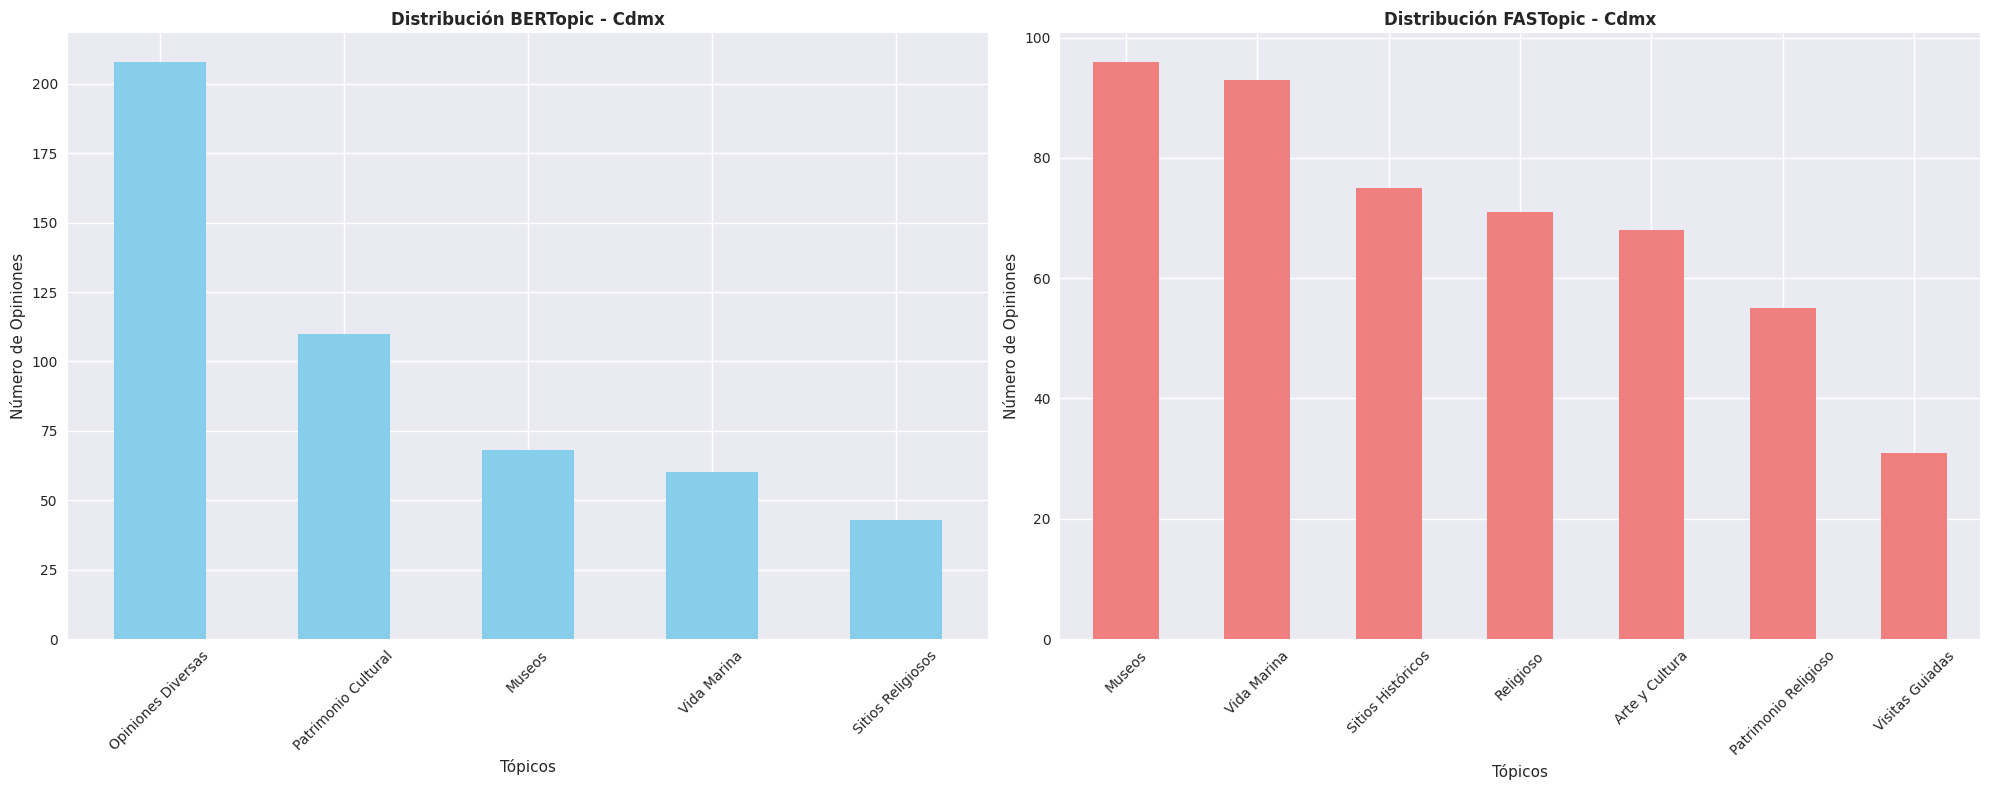


üìà TOP 5 T√ìPICOS POR M√âTODO:

üîµ BERTopic:
   1. Opiniones Diversas: 208 (42.5%)
   2. Patrimonio Cultural: 110 (22.5%)
   3. Museos: 68 (13.9%)
   4. Vida Marina: 60 (12.3%)
   5. Sitios Religiosos: 43 (8.8%)

üî¥ FASTopic:
   1. Museos: 96 (19.6%)
   2. Vida Marina: 93 (19.0%)
   3. Sitios Hist√≥ricos: 75 (15.3%)
   4. Religioso: 71 (14.5%)
   5. Arte y Cultura: 68 (13.9%)

üí° OBSERVACIONES:
   ‚Ä¢ FASTopic identific√≥ 7 t√≥picos vs 5 de BERTopic
   ‚Ä¢ FASTopic muestra mayor granularidad en la segmentaci√≥n
   ‚Ä¢ Tiempo FASTopic: 45.17s (m√°s r√°pido que BERTopic)

üìä RESUMEN ACTUAL FASTopic:
   Total t√≥picos identificados: 7
   T√≥picos en datos actuales: 7
   Documentos procesados: 489


In [ ]:
# ===== COMPARACI√ìN CON BERTOPIC =====

if 'TopicoConBERTopic' in df.columns:
    print(f"üîÑ COMPARACI√ìN FASTopic vs BERTopic en {CIUDAD_ANALIZAR}")
    print("=" * 60)
    
    # Usar datos actuales procesados en lugar de df_ciudad que puede tener datos previos
    df_comparacion = df_con_topicos[
        df_con_topicos.index.isin(df_ciudad[df_ciudad['TopicoConBERTopic'].notna()].index)
    ].copy()
    
    # Agregar datos de BERTopic al dataframe de comparaci√≥n
    bertopic_data = df_ciudad[df_ciudad['TopicoConBERTopic'].notna()]['TopicoConBERTopic']
    df_comparacion = df_comparacion[df_comparacion.index.isin(bertopic_data.index)].copy()
    df_comparacion['TopicoConBERTopic'] = bertopic_data
    
    if len(df_comparacion) > 0:
        print(f"üìä Opiniones con ambos an√°lisis: {len(df_comparacion)}")
        
        # Comparar n√∫mero de t√≥picos √∫nicos usando datos actuales
        topicos_bertopic = df_comparacion['TopicoConBERTopic'].nunique()
        topicos_fastopic = df_comparacion['Topico_Nombre'].nunique()  # Usar datos actuales
        
        print(f"\nüéØ N√öMERO DE T√ìPICOS:")
        print(f"   BERTopic: {topicos_bertopic}")
        print(f"   FASTopic: {topicos_fastopic}")
        
        # Mostrar distribuciones lado a lado
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        # BERTopic
        bertopic_counts = df_comparacion['TopicoConBERTopic'].value_counts().head(10)
        bertopic_counts.plot(kind='bar', ax=axes[0], color='skyblue')
        axes[0].set_title(f'Distribuci√≥n BERTopic - {CIUDAD_ANALIZAR}', fontweight='bold')
        axes[0].set_xlabel('T√≥picos')
        axes[0].set_ylabel('N√∫mero de Opiniones')
        axes[0].tick_params(axis='x', rotation=45)
        
        # FASTopic - usar datos actuales
        fastopic_counts = df_comparacion['Topico_Nombre'].value_counts().head(10)
        fastopic_counts.plot(kind='bar', ax=axes[1], color='lightcoral')
        axes[1].set_title(f'Distribuci√≥n FASTopic - {CIUDAD_ANALIZAR}', fontweight='bold')
        axes[1].set_xlabel('T√≥picos')
        axes[1].set_ylabel('N√∫mero de Opiniones')
        axes[1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # An√°lisis de concordancia (t√≥picos m√°s frecuentes)
        print(f"\nüìà TOP 5 T√ìPICOS POR M√âTODO:")
        print(f"\nüîµ BERTopic:")
        for i, (topico, count) in enumerate(bertopic_counts.head(5).items(), 1):
            pct = (count / len(df_comparacion) * 100)
            print(f"   {i}. {topico}: {count} ({pct:.1f}%)")
        
        print(f"\nüî¥ FASTopic:")
        for i, (topico, count) in enumerate(fastopic_counts.head(5).items(), 1):
            pct = (count / len(df_comparacion) * 100)
            print(f"   {i}. {topico}: {count} ({pct:.1f}%)")
            
        print(f"\nüí° OBSERVACIONES:")
        print(f"   ‚Ä¢ FASTopic identific√≥ {topicos_fastopic} t√≥picos vs {topicos_bertopic} de BERTopic")
        if topicos_fastopic > topicos_bertopic:
            print(f"   ‚Ä¢ FASTopic muestra mayor granularidad en la segmentaci√≥n")
        elif topicos_fastopic < topicos_bertopic:
            print(f"   ‚Ä¢ FASTopic agrupa conceptos de manera m√°s generalizada")
        else:
            print(f"   ‚Ä¢ Ambos m√©todos identificaron el mismo n√∫mero de t√≥picos")
            
        print(f"   ‚Ä¢ Tiempo FASTopic: {tiempo_entrenamiento:.2f}s (m√°s r√°pido que BERTopic)")
        
        # Mostrar resumen de datos actuales de FASTopic
        print(f"\nüìä RESUMEN ACTUAL FASTopic:")
        print(f"   Total t√≥picos identificados: {len(topic_info)}")
        print(f"   T√≥picos en datos actuales: {df_con_topicos['Topico_Nombre'].nunique()}")
        print(f"   Documentos procesados: {len(df_con_topicos)}")
        
    else:
        print(f"‚ö†Ô∏è No hay opiniones de {CIUDAD_ANALIZAR} con ambos an√°lisis completados")
        print(f"   BERTopic disponible: {df_ciudad['TopicoConBERTopic'].notna().sum()} opiniones")
        print(f"   FASTopic actual: {len(df_con_topicos)} opiniones")
else:
    print(f"‚ÑπÔ∏è No hay an√°lisis previo de BERTopic para comparar")
    print(f"   Ejecuta el notebook 07-modelado-de-topicos-con-bertopic.ipynb primero")
    

In [ ]:
generar_reporte_fastopic(
    topic_info, 
    len(df_con_topicos), 
    CIUDAD_ANALIZAR, 
    tiempo_entrenamiento
)

df.to_csv('../data/processed/dataset_opiniones_analisis.csv', index=False)

üìã REPORTE COMPLETO - AN√ÅLISIS CON FASTOPIC
üéØ AN√ÅLISIS COMPLETADO:
   üìç Ciudad: Cdmx
   üìÑ Documentos analizados: 489
   üè∑Ô∏è T√≥picos identificados: 7
   ‚è±Ô∏è Tiempo de entrenamiento: 45.17 segundos

üìä ESTAD√çSTICAS DE T√ìPICOS:
   üéØ T√≥pico m√°s relevante: Vida Marina
   üìà Peso m√°ximo: 87.834
   üìâ Peso m√≠nimo: 56.157
   üìä Peso promedio: 69.857

üèÜ TOP 5 T√ìPICOS POR RELEVANCIA:
   1. Vida Marina
      üìä Peso: 87.834 | üìÑ Documentos: 190
      üîë Palabras clave: animal, acu, grupo, cuidado, servicio, nino, activ...
   2. Sitios Hist√≥ricos
      üìä Peso: 75.433 | üìÑ Documentos: 217
      üîë Palabras clave: ciudad, plaza, mexico, templo, centro, catedral, r...
   3. Religioso
      üìä Peso: 74.834 | üìÑ Documentos: 244
      üîë Palabras clave: misa, tour, duda, pareja, fe, bas, milagro, recome...
   4. Patrimonio Religioso
      üìä Peso: 66.983 | üìÑ Documentos: 265
      üîë Palabras clave: iglesia, mercado, barrio, virgen, cap

In [ ]:
# ===== EVALUACI√ìN DE M√âTRICAS FASTOPIC =====

print(f"üî¨ Evaluando modelo FASTopic para {CIUDAD_ANALIZAR}...")

topics_words_fastopic = extraer_palabras_fastopic(top_words, words_per_topic=10)
metricas_fastopic = evaluar_modelo_topicos(texts, topics_words_fastopic, f"FASTopic - {CIUDAD_ANALIZAR}")

mostrar_metricas(metricas_fastopic)

üî¨ Evaluando modelo FASTopic para Cdmx...


üìä Evaluaci√≥n FASTopic - Cdmx:
   üéØ T√≥picos: 7
   üìà Coherencia CV: 0.3598
   üîÑ Diversidad: 0.9857
